In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from qiskit import IBMQ
import sklearn.datasets as skd
from sklearn.model_selection import train_test_split
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.aqua.algorithms import QSVM, VQC
from qiskit.providers.ibmq import least_busy
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from sklearn.datasets import make_blobs
from imblearn.under_sampling import RandomUnderSampler
import math
import funcs
#https://www.kaggle.com/merishnasuwal/breast-cancer-prediction-dataset

In [2]:
ds = pd.read_csv('heart.csv')
ds.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<AxesSubplot:xlabel='output', ylabel='count'>

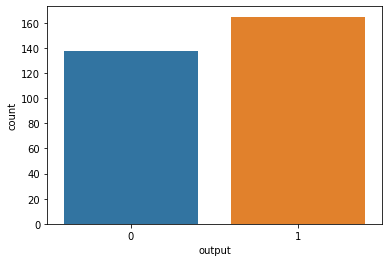

In [3]:
sns.countplot(x = 'output', data =ds)

In [4]:
#defining dependent and independent variables
X = ds.drop('output', axis=1)
y = ds['output']

In [5]:
# from imblearn.combine import SMOTETomek 
# rus = SMOTETomek(random_state=42)
# X, y_ = rus.fit_resample(X, y)

In [6]:
X.shape

(303, 13)

In [7]:
# X = X.values
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [8]:
X

array([[ 0.9521966 ,  0.68100522,  1.97312292, ..., -2.27457861,
        -0.71442887, -2.14887271],
       [-1.91531289,  0.68100522,  1.00257707, ..., -2.27457861,
        -0.71442887, -0.51292188],
       [-1.47415758, -1.46841752,  0.03203122, ...,  0.97635214,
        -0.71442887, -0.51292188],
       ...,
       [ 1.50364073,  0.68100522, -0.93851463, ..., -0.64911323,
         1.24459328,  1.12302895],
       [ 0.29046364,  0.68100522, -0.93851463, ..., -0.64911323,
         0.26508221,  1.12302895],
       [ 0.29046364, -1.46841752,  0.03203122, ..., -0.64911323,
         0.26508221, -0.51292188]])

In [9]:
def nextPowerOf2(n):
    p = 1
    if (n and not(n & (n - 1))):
        return n
    while (p < n) :
        p <<= 1     
    return p;

In [10]:
# Rotator
from typing import Callable, List, Optional, Tuple, Union
from math import atan2
def rotate_matrix_nd(bs,degrees):
    ang = np.deg2rad(degrees)
    dim = np.shape(bs)[0]
    Rot_mat = np.eye(dim)
    for k in range(0,dim-2):
        for l in range(dim-1,k,-1):
            a = atan2(bs[l,k],bs[l-1,k])
            R = np.eye(dim)
            R_temp = np.array([[np.cos(a),np.sin(a)],[-1*np.sin(a),np.cos(a)]])
            tmp = l - 1
            R[tmp:tmp+R_temp.shape[0],tmp:tmp+R_temp.shape[0]] = R_temp
            bs=np.matmul(R,bs)
            Rot_mat = np.matmul(R,Rot_mat)
    R = np.eye(dim)
    R[dim-2:dim,dim-2:dim] = np.array([[np.cos(ang),-1*np.sin(ang)],[np.sin(ang),np.cos(ang)]])
    Rot_mat = np.matmul(np.linalg.inv(Rot_mat),np.matmul(R,Rot_mat))
    return Rot_mat

In [11]:
dim = 13
v = np.logical_or(np.eye(dim),np.fliplr(np.eye(dim))).astype(int)
v = v[:,:-2]
# v = np.eye(dim)[:,:-2]
# v[-2][0] = 1
# v[-1][1] = 1

In [12]:
for x in range(-10,11,1):
    print(x)


-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10


# VQC - Amplitude Encoding Mottonen Method

In [13]:
y = y.values
# number of qubits
n = 4
num_qubits = n # needed for D&C
# set random seed
np.random.seed(42)
# number of samples
num_data = len(y) # 100
# number of training samples
num_train = int(0.75*num_data) # 75
# number of parameterized layers
layers = 7 #5
batch_size = 15#20
iterations = 15#20
# initial parameters
params_init = np.random.randn(layers, n, 3)*0.01
bias_init = 0.01
learning_rate = 0.01
momentum = 0.05
# set backend to run 
backend = Aer.get_backend('qasm_simulator')
    
for angul in range(-10,11,1):
    print("Voy en "+str(angul))
    rot = rotate_matrix_nd(v,angul)
    XX = np.empty((0,dim))
    for point in X:
        tmp_point = np.matmul(rot,np.atleast_2d(point).T)
        tmp_point = np.atleast_2d(tmp_point).T
        XX = np.append(XX, tmp_point,axis=0)
    
    X = XX
    padding_X = 0.3*np.ones((len(X), nextPowerOf2(len(X[0]))-len(X[0])))
    X_pad = np.c_[np.c_[X, padding_X], np.zeros((len(X), 0))]
    X_pad
#     print("First X sample (original)  :", X_pad[0])
    # normalize each input
    normalization = np.sqrt(np.sum(X**2, -1))
    X_norm = (X_pad.T / normalization).T
#     print("First X sample (normalized):", X_norm[0])

    # angles for state preparation are new features; impute nans
    features = np.array([funcs.get_angles(x, n) for x in X_norm])
    features = np.nan_to_num(features)
    feats_train, feats_val, Y_train, Y_val = train_test_split(features, y, test_size=0.4,  shuffle=True, random_state=42)
    
    # train model
    var, bias, Y_val, pred_val = funcs.train_model(n, layers, params_init, bias_init, batch_size, learning_rate, momentum, iterations, feats_train, Y_train, feats_val, Y_val, features, y,angul)
    

Voy en -10
Voy en -9
Voy en -8
Voy en -7
Voy en -6
Voy en -5
Voy en -4
Voy en -3
Voy en -2
Voy en -1
Voy en 0
Voy en 1
Voy en 2
Voy en 3
Voy en 4
Voy en 5
Voy en 6
Voy en 7
Voy en 8
Voy en 9


/home/nemo/anaconda3/envs/qiskit/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nemo/anaconda3/envs/qiskit/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nemo/anaconda3/envs/qiskit/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Voy en 10


# Classic SVM

In [16]:
from sklearn import svm
sample_train, sample_test, label_train, label_test = train_test_split(XX, y, test_size=0.10,  shuffle=True, random_state=42)

In [17]:
clf = svm.SVC(gamma='scale')
clf.fit(sample_train, label_train)

SVC()

In [18]:
print(classification_report(label_test, clf.predict(sample_test) , zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



KeyboardInterrupt: 

In [28]:
print(classification_report(Y_val, pred_val))

              precision    recall  f1-score   support

           0       0.49      0.89      0.63        35
           1       0.69      0.22      0.33        41

    accuracy                           0.53        76
   macro avg       0.59      0.55      0.48        76
weighted avg       0.60      0.53      0.47        76



In [353]:
Y_val

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1])

In [354]:
pred_val

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])